# ライブラリ

In [12]:
# !python -V
!nvcc --version
# !pip show torch

import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
True
12.1
2.2.2
Tue Aug 13 05:59:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8      

In [13]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [22]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)
#ライブラリ
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
import seaborn as sns; sns.set() # グラフ描画用


import pandas as pd

from pycm import ConfusionMatrix

import csv

import time
from datetime import datetime
import pytz

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# UndefinedMetricWarning のみを抑制
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

0.10.2.post1
2.2.2


# データセットの作成

In [23]:
sr = 44100 #サンプリング周波数

## 試行ごとに分割

In [24]:


# #ファイルパスの指定
# origin_data = "data/origin_data/origindata_20240619"

# #学習用データの読み込み
# audio_dir = origin_data
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+".WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)
#     print(subFolder)
# #1データから30試行をトリミングを22パターン分行い，soundDataset_new_newに格納する
# # soundDataset_new_newの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset_new =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset_new = np.append(soundDataset_new,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset_new = soundDataset_new.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset_new.shape)

# import pickle
# f = open('soundDataset_20240619.pickle','wb')
# pickle.dump(soundDataset_new,f)

### ラベルを含んだデータセット化

In [25]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [26]:
#object層
objLabel = [
    "button-down", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "steal shelf", 
    
    "wooden desk", 
    "wooden shelf", 
    "floor", 
    
    "accessory case", 
    "plastic container", 
    "plastic shelf"
]
objNum= list(range(21))

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [27]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [28]:
# # num_feature次元のMFCCのデータフレームを作成

# # ファイル名の生成と追加
# filenames = []
# for target_num in range(21):
#     for trial in range(50):
#         filenames.append(f'trim-data_{target_num}_{trial}.wav')

# Dataset = pd.DataFrame()

# Dataset['filename'] = filenames
# Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
# Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
# Dataset['shNum'] = np.array([0]*450 + [1]*600)

# # データセットに'objLabel'の列を追加
# Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # # データセットに'matLabel'の列を追加
# Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # # データセットに'SHLabel'の列を追加
# Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# # データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset.csv'
# Dataset.to_csv(csv_path, index=False)

# # Display the DataFrame
# pd.set_option('display.max_rows', 100)


Dataset = pd.read_csv('data/meta_data/dataset.csv')
Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [29]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])
        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [30]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,...,3.645248,3.399917,3.804335,3.734329,0,0,0,button-down,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,...,3.640349,3.322606,3.285746,3.343535,0,0,0,button-down,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,...,3.156580,3.407280,3.517655,3.547526,0,0,0,button-down,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,...,3.725960,3.272637,3.092343,3.604951,0,0,0,button-down,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,...,3.328177,3.571923,3.805326,4.301650,0,0,0,button-down,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,...,3.297809,3.660277,3.493659,4.016997,20,6,1,plastic shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,...,3.441372,3.365149,3.482850,4.577083,20,6,1,plastic shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,...,3.539720,3.766647,4.083665,4.772348,20,6,1,plastic shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,...,3.418645,3.032147,3.479765,4.267387,20,6,1,plastic shelf,plastic,hard


### メルスペクトログラムのデータセット

In [31]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
Dataset_melspec = np.expand_dims(Dataset_melspec,1)

print(Dataset_melspec.shape)
print(type(Dataset_melspec))

# ラベルのデータセット
Dataset_label = Dataset.iloc[:,1:4]
Dataset_label_np = Dataset_label.to_numpy()

Dataset_melspec_svm = Dataset_melspec.reshape(Dataset_melspec.shape[0], -1)
print(Dataset_melspec_svm.shape)

(1050, 1, 128, 130)
<class 'numpy.ndarray'>
(1050, 16640)


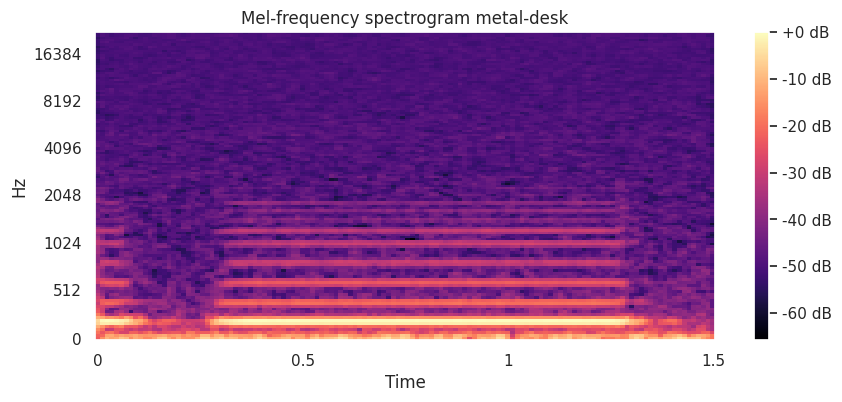

In [32]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(Dataset_melspec[600,0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
title = 'Mel-frequency spectrogram metal-desk'
plt.title(title)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# plt.tight_layout()
title
plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
plt.show()

### データ分割

In [33]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)



In [34]:
# テンソルに変換
Dataset_melspec_tensor = torch.tensor(Dataset_melspec, dtype=torch.float32)
Dataset_label_tensor = torch.tensor(Dataset_label_np, dtype=torch.int64)

# split (stratify by the first column of labels as an example)
train_feature_all, eval_feature_all, train_labels_all, eval_labels_all = train_test_split(
    Dataset_melspec_tensor, Dataset_label_tensor, 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.8
)

val_feature_all, test_feature_all, val_labels_all, test_labels_all = train_test_split(
    eval_feature_all, eval_labels_all, 
    stratify=eval_labels_all[:, 0], shuffle=True, random_state=0, train_size=0.2
)


test_feature_all = eval_feature_all
test_labels_all = eval_labels_all

print(train_labels_all.shape,test_labels_all.shape)


torch.Size([840, 3]) torch.Size([210, 3])


In [35]:
# 学習データにない物体の評価用データセットの作成
def Make_other_dataset(num):

    start = num*trials
    end = (num+1)*trials

    #テストデータの抽出
    test_feature = Dataset_melspec_tensor[start:end,:,:,:]
    test_labels = Dataset_label_tensor[start:end,:]

    #テストデータ以外でデータセットを作成
    other_feature = torch.cat((Dataset_melspec_tensor[:start,:,:,:],Dataset_melspec_tensor[end:,:,:,:]),dim=0)
    other_labels = torch.cat((Dataset_label_tensor[:start,:],Dataset_label_tensor[end:,:]),dim=0)

    #trainとvalに分割
    train_feature, val_feature, train_labels, val_labels = train_test_split(
        other_feature, other_labels, 
    stratify=other_labels[:, 0], shuffle=True, random_state=0, train_size=0.8
    )   
    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels

# 使用
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

In [36]:
def Alldataset():
    train_feature=train_feature_all
    train_labels=train_labels_all
    val_feature=val_feature_all
    val_labels=val_labels_all
    test_feature=test_feature_all
    test_labels=test_labels_all

    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels


# 評価

## t-SNEで特徴量空間の可視化

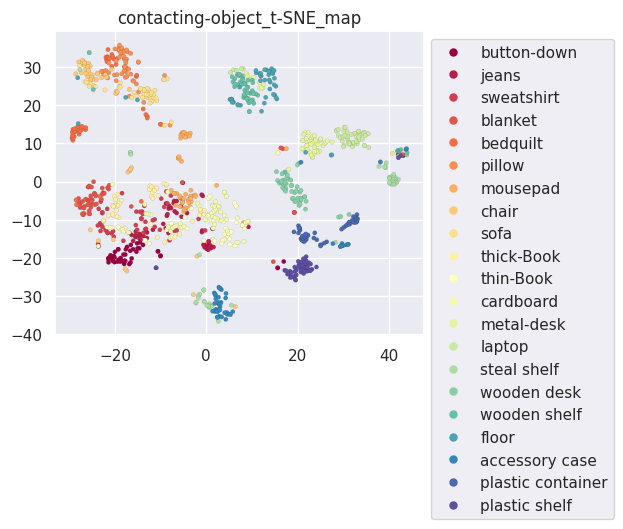

In [37]:


tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=(0)
)
X_tsne = tsne.fit_transform(Dataset_mfcc.iloc[:,1:num_feature])

# プロット
title = "contacting-object_t-SNE_map"
plt.title(title)

scatter=plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            c=Dataset_mfcc['objNum'], 
            cmap='Spectral',
            edgecolor='black',
            linewidths=0.05,
            s=10 
        )  
# 凡例を追加
plt.legend(handles=scatter.legend_elements(num=21)[0],labels=objLabel,bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# plt.savefig("data/output_data/"+title+".pdf")

## SVMでの評価

In [ ]:
def Eval_svm(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 10 #分割数
    stratifiedkfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)


In [ ]:
def Eval_svm_LOOO(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 21 #分割数
    stratifiedkfold = KFold(n_splits=folds, shuffle=False)

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)

### object層

In [ ]:
# Eval_svm(
#     "object",
#     Dataset_mfcc.iloc[:,1:num_feature],
#     Dataset_mfcc.obj,
#     objLabel,
#     False
#     )

In [ ]:
Eval_svm_LOOO(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

In [ ]:
print( Dataset_mfcc.obj)

### material層

In [ ]:
Eval_svm(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

In [ ]:
Eval_svm_LOOO(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

### soft-hard層

In [ ]:
Eval_svm(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

In [ ]:
Eval_svm_LOOO(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

### 提案手法適用時の評価

In [ ]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc = []
train_label_mfcc = []
eval_data_mfcc = []
eval_label_mfcc = []

train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.8
)


In [ ]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.objNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
# Dec = model.predict_proba(eval_data_mfcc)
Dec = model.decision_function(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = objLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.objNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

In [ ]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
Up_object = df[df['decision'] >= average_decision_object]


print(classification_report(Up_object['Actual'], Up_object['prediction'],digits=3))

print("採用数:", len(Up_object.index))
print("採用率:", len(Up_object.index)/len_df)
# 閾値未満を抽出しDFを作成
Down_object = df[df['decision'] < average_decision_object]

print("不採用数:",Down_object.shape)
# Down_object


In [ ]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.matNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
# Dec = model.predict_proba(eval_data_mfcc)
Dec = model.decision_function(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = matLabel)

df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.matNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

In [ ]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_object.index]
Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape)


In [ ]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec)

df = pd.DataFrame(Dec,columns = shLabel)
print(df)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

In [ ]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_material.index]
print(df)
print(classification_report(df['Actual'], df['prediction'],digits=3))

Up_softhard = df[df['decision'] >= average_decision_softhard]

print(Up_softhard.shape)
print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape)


In [ ]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = shLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

In [ ]:

df = df.iloc[Down_softhard.index]


print(classification_report(df['Actual'], df['prediction'],digits=3))

### 学習データにない物体の評価

In [ ]:
subject = "object"
trainDataset = Dataset_mfcc.iloc[:,1:num_feature]
labelDataset = Dataset_mfcc.objNum
target = objLabel
save = False

#機械学習アルゴリズムの選択
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 

#10分割交差検証
folds = 21 #分割数
stratifiedkfold = KFold(n_splits=folds, shuffle=False)

pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
proba = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold,method='predict_proba')
print(proba,proba.shape)
#classification_reportの作成
report = classification_report(labelDataset, pred,digits=3,target_names=target)
print(report)

#混同行列の作成
cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                label=target,
                xticklabels=target,
                yticklabels=target)
title = "confusion_matrix_"+subject
plt.title(title)
plt.xlabel('predict')
plt.ylabel('actual')

#保存設定
if save == True:
    plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
    with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
        print(report)


df = pd.DataFrame(proba,columns = target)
df["decision"] = np.max(proba, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(labelDataset)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df





In [ ]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
# filtered_rows = df[df['prediction'] == df['Actual']]

# print(filtered_rows)

# average_decision_object = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
Up_object = df[df['decision'] >= average_decision_object]


print(classification_report(Up_object['Actual'], Up_object['prediction'],digits=3))

print("採用数:", len(Up_object.index))
print("採用率:", len(Up_object.index)/len_df)
# 閾値未満を抽出しDFを作成
Down_object = df[df['decision'] < average_decision_object]

print("不採用数:",Down_object.shape)
# Down_object

In [ ]:
subject = "material"
trainDataset = Dataset_mfcc.iloc[:,1:num_feature]
labelDataset = Dataset_mfcc.matNum
target = matLabel
save = False

#機械学習アルゴリズムの選択
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 

#10分割交差検証
folds = 21 #分割数
stratifiedkfold = KFold(n_splits=folds, shuffle=False)

pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
proba = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold,method='predict_proba')
print(proba,proba.shape)
#classification_reportの作成
report = classification_report(labelDataset, pred,digits=3,target_names=target)
print(report)

#混同行列の作成
cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                label=target,
                xticklabels=target,
                yticklabels=target)
title = "confusion_matrix_"+subject
plt.title(title)
plt.xlabel('predict')
plt.ylabel('actual')

#保存設定
if save == True:
    plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
    with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
        print(report)


df = pd.DataFrame(proba,columns = target)
df["decision"] = np.max(proba, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(labelDataset)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df


In [ ]:
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成


df = df.iloc[Down_object.index]
Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape)

In [ ]:
subject = "soft-hard"
trainDataset = Dataset_mfcc.iloc[:,1:num_feature]
labelDataset = Dataset_mfcc.shNum
target = shLabel
save = False

#機械学習アルゴリズムの選択
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 

#10分割交差検証
folds = 21 #分割数
stratifiedkfold = KFold(n_splits=folds, shuffle=False)

pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
proba = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold,method='predict_proba')
print(proba,proba.shape)
#classification_reportの作成
report = classification_report(labelDataset, pred,digits=3,target_names=target)
print(report)

#混同行列の作成
cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                label=target,
                xticklabels=target,
                yticklabels=target)
title = "confusion_matrix_"+subject
plt.title(title)
plt.xlabel('predict')
plt.ylabel('actual')

#保存設定
if save == True:
    plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
    with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
        print(report)


df = pd.DataFrame(proba,columns = target)
df["decision"] = np.max(proba, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(labelDataset)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df



In [ ]:
df = df.iloc[Down_material.index]
print(df)
print(classification_report(df['Actual'], df['prediction'],digits=3))

Up_softhard = df[df['decision'] >= average_decision_softhard]

print(Up_softhard.shape)
print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape)

### メルスペクトログラムでSVM評価

In [ ]:
Eval_svm(
    "object",
    Dataset_melspec_svm,
    Dataset_mfcc.obj,
    objLabel,
    False
    )

In [ ]:
Eval_svm(
    "material",
    Dataset_melspec_svm,
    Dataset_mfcc.mat,
    matLabel,
    False
    )

In [ ]:
Eval_svm(
    "soft-hard",
    Dataset_melspec_svm,
    Dataset_mfcc.sh,
    shLabel,
    False
    )

## CNNでの評価

In [39]:
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

### モデルの保存関数

In [40]:
def Time():
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')
    # 現在の日本時間を取得
    now = datetime.now(jst)
    # 時刻を指定された形式の文字列に変換
    time = now.strftime("%Y%m%d%H%M")

    return time

In [41]:
def SaveModel(model,modelname):
    time = Time()
    model_path = 'data/models_saved/'+time+"_"+modelname+'.pth'
    torch.save(model, model_path)

# #読み込み用
# model_path = 'data/models_saved/202406302329_shModel_2.pth'
# xModel = torch.load(model_path)

### 評価関数

In [42]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN(data_loader,device,num_label,num_trial):
    with torch.no_grad():
        if num_label == 0:
            model = shModel_trained
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            model = matModel_trained
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            model = objModel_trained
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            confidence = y[0]
            print(y[0].shape)
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "Confusion_matrix_"+model_name
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        plt.title(title)
        plt.xlabel('Predict')
        plt.ylabel('Actual')
        plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

In [43]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN_trained(data_loader,device,num_label,num_trial,model):
    with torch.no_grad():
        if num_label == 0:
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            print(y)
            confidence = y[0]
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "Confusion_matrix_"+model_name
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        plt.title(title)
        plt.xlabel('Predict')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('data/output_data/'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

### soft-hard 1

In [ ]:
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [ ]:
# モデルのインポート・構築

from models.dymn.model import get_model as get_dymn
shModel = get_dymn(pretrained_name="dymn10_as")

#パラメータを固定
for param in shModel.parameters():
    param.requires_grad = True

#classifierのネットワーク構造を変更・パラメータの更新を許可
shModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.Linear(in_features=527, out_features=2, bias=True),  # 新しい層
)
print(shModel)

In [ ]:
# 学習と評価

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = shModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.1) and epoch<max_epoch:
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

model_name = 'shModel_1'    
shModel_trained = net1
SaveModel(shModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,0,1)

print(report)


In [ ]:
print(confidences)

### material 1

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [ ]:
# モデルのインポート・構築

matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=7, bias=True),  # 新しい層
)
print(matModel)

In [ ]:
#学習と評価
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1



model_name = 'matModel_1'    
matModel_trained = net2
SaveModel(matModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,1,1)

print(report)



### object 1

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [ ]:
# モデルのインポート・構築

objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=21, bias=True),  # 新しい層
)
print(objModel)

In [ ]:
# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



model_name = 'objModel_1'    
objModel_trained = net3
SaveModel(objModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,2,1)

print(report)


### soft-hard 2

In [ ]:
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [ ]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層  
    nn.Softmax(dim=1)
)
print(shModel_2)

In [ ]:
# 学習と評価

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.4) and epoch<max_epoch:
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

model_name = 'shModel_2'    
shModel_trained = net4
SaveModel(shModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report , shConfidences= EvalCNN(test_loader,device,0,2)

print(report)


### material 2

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [ ]:
matModel_2 = shModel_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_grad = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=88, out_features=7, bias=True),  # 新しい層  
    nn.Softmax(dim=1)

)
print(matModel_2)

In [ ]:
#学習と評価
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
min_epoch = 100
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.2) and epoch<max_epoch :
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1



model_name = 'matModel_2'    
matModel_trained = net5
SaveModel(matModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, matConfidences = EvalCNN(test_loader,device,1,2)

print(report)



### object 2

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [ ]:
objModel_2 = matModel_trained

# パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_grad =  True

# 新しい層の追加とBatch Normalizationの導入
objModel_2.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.Softmax(dim=1)

)

print(objModel_2)


In [ ]:
# エポックの数
max_epoch = 500
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



model_name = 'objModel_2'    
objModel_trained = net6
SaveModel(objModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report , objConfidences= EvalCNN(test_loader,device,2,2)

print(report)


## DPSWS 評価

In [141]:
# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [142]:
model_path = 'data/models_saved/202406302320_shModel_1.pth'
shModel_eval = torch.load(model_path)
print(shModel_eval)
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,1,shModel_eval)
print(shReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [143]:
model_path = 'data/models_saved/202406302324_matModel_1.pth'
matModel_eval = torch.load(model_path)
print(matModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,1,matModel_eval)
print(matReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [144]:
model_path = 'data/models_saved/202406302328_objModel_1.pth'
objModel_eval = torch.load(model_path)
print(objModel_eval)

#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,1,objModel_eval)
print(objReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

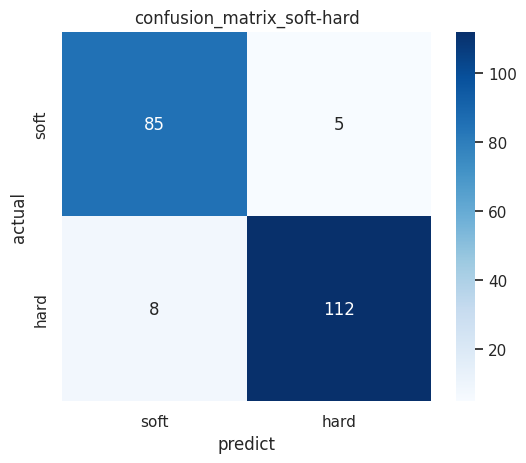

In [262]:
model_path = 'data/models_saved/202406302329_shModel_2.pth'
shModel_eval = torch.load(model_path)
print(shModel_eval)
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,2,shModel_eval)
print(shReport)

MakeConfusionMatrix(actual = shActuals,
predict = shPreds,
target = shLabel,
subject = 'soft-hard')

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

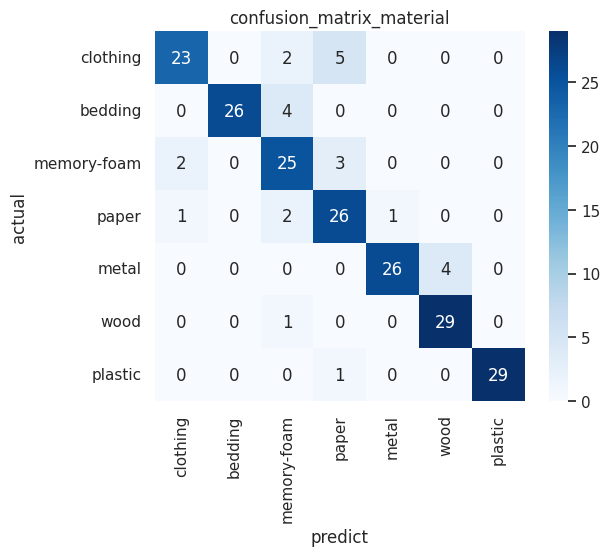

In [261]:
model_path = 'data/models_saved/202406302329_matModel_2.pth'
matModel_eval = torch.load(model_path)
print(matModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,2,matModel_eval)
print(matReport)

MakeConfusionMatrix(actual = matActuals,
predict = matPreds,
target = matLabel,
subject = 'material')

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

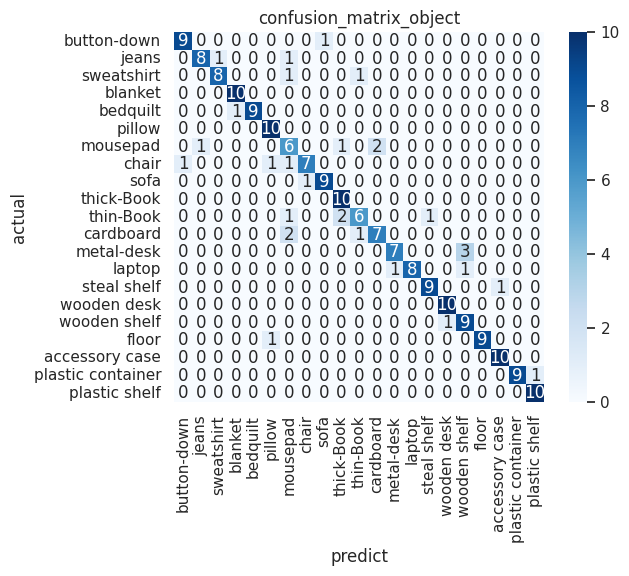

In [260]:
model_path = 'data/models_saved/202406302343_objModel_2.pth'
objModel_eval = torch.load(model_path)
print(objModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,2,objModel_eval)
print(objReport)

MakeConfusionMatrix(actual = objActuals,
predict = objPreds,
target = objLabel,
subject = 'object')

### 提案手法適用時の評価

In [148]:
# print(shConfidences)
# print(matConfidences)
# print(objConfidences[100])

In [149]:
# array = objConfidences[100]
# exp_array = np.exp(array)
# # exp_array = array
# softmax_array = np.round((exp_array / np.sum(exp_array, axis=0, keepdims=True)),3)

# print(softmax_array)

In [150]:
def Hiera_report(confidences,label,preds,actuals):
    array = np.array(confidences)
    print(array.shape)
    # 行ごとにSoftmax関数を適用
    # exp_array = np.exp(array)
    # softmax_array = np.round((exp_array / np.sum(exp_array, axis=1, keepdims=True)),3)

    # print(softmax_array)

    # df = pd.DataFrame(softmax_array,columns = label)
    df = pd.DataFrame(array,columns = label)
    # df["decision"] = np.max(Dec, axis=1)
    df["prediction"] = np.array(preds)
    df['Actual'] = np.array(actuals)
    # df["decision"] = np.max(softmax_array, axis=1)
    df["decision"] = np.max(array, axis=1)
    pd.set_option('display.max_rows',100)
    pd.set_option('display.max_columns',None)


    len_df = len(df.index)

    return df , len_df

In [191]:
def MapConfidence(df,level,avg):
    ##mapping decision

    true_trial = df[df['prediction'] == df['Actual']]
    false_trial = df[df['prediction'] != df['Actual']]

    true_trial
    false_trial

    x_true = true_trial.index
    y_true = true_trial['decision']


    x_false = false_trial.index
    y_false = false_trial['decision']

    print(x)

    fig = plt.figure()

    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_true,y_true,label='True')
    ax.scatter(x_false,y_false,label='False')

    ax.hlines(avg,0,len(df),colors='r',label='average')

    # 5. タイトル、軸ラベルを設定
    ax.set_title('Estimation confidences at '+level+' level')  
    ax.set_xlabel('Index')
    ax.set_ylabel('Confidence')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


    # 6. show
    plt.show()

In [192]:
# array = [0.3,0.3,0.4,0.2]
# exp_array = np.exp(array)
# softmax_array = np.round((exp_array / np.sum(exp_array, axis=1, keepdims=True)),3)

In [193]:
#mapping decision
df,len_df = Hiera_report(objConfidences,objLabel,objPreds,objActuals)

# print(df.prediction,df.Actual)
df

(210, 21)


,button-down,jeans,sweatshirt,blanket,bedquilt,pillow,mousepad,chair,sofa,thick-Book,thin-Book,cardboard,metal-desk,laptop,steal shelf,wooden desk,wooden shelf,floor,accessory case,plastic container,plastic shelf,prediction,Actual,decision
0,2.411845,-0.122896,-0.606207,-4.324915,-2.231772,-1.388398,3.397088,-1.897428,-0.212869,-7.779583,-0.559867,1.554498,1.305395,2.514073,-0.773821,0.720556,1.422216,22.198339,-2.097382,-2.782344,-3.526391,17,17,22.198339
1,-0.270852,-4.971002,2.988255,22.919485,3.318503,0.815073,-0.417611,-1.952357,-1.109730,-2.362839,-1.753096,-5.711610,0.353884,-0.431600,-5.164983,-1.384434,0.565311,-5.917487,-0.186655,1.251877,-2.642659,3,4,22.919485
2,1.328981,-1.642048,-3.054834,0.114375,-3.093427,1.201046,-5.479822,-4.067848,-4.138005,-3.202519,1.018601,3.664458,3.728379,-6.774724,1.296544,5.016629,25.580162,2.217013,0.610258,-6.921119,-3.650828,16,16,25.580162
3,-1.223480,-1.488337,-1.817849,0.989899,0.883177,7.597976,2.476688,1.288269,2.678084,-1.008840,-1.830144,-1.576396,-1.388872,-0.132059,-3.167856,-0.506408,-0.264304,2.672705,0.065877,-1.442800,-1.003147,5,17,7.597976
4,1.706369,0.148786,-0.397034,-4.134669,-1.725217,-0.919322,2.085314,-1.794083,0.012032,-6.813890,-0.351600,1.397688,1.516756,2.649422,-0.039848,0.422335,1.709356,20.181393,-2.185179,-2.815792,-3.564688,17,17,20.181393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,-0.031610,3.856924,15.150069,1.397447,2.386186,-3.357179,2.292061,-5.102784,-0.076555,0.329528,0.759190,-2.095357,-1.150060,-2.056188,-3.677077,0.100361,-3.335176,0.196118,-2.723022,-1.090345,-1.820220,2,2,15.150069
206,-0.975848,-0.546382,-4.872843,3.455078,3.627404,19.020523,1.686713,0.667960,-1.687379,-0.132359,-2.433427,-2.133089,-0.592262,-0.581505,-4.328208,-4.852817,-0.371558,-1.985115,0.647412,-3.163607,0.999654,5,5,19.020523
207,-0.148464,-4.613915,3.354406,22.582739,2.897032,0.639272,-0.924271,-1.889555,-1.058569,-2.356640,-1.771982,-5.677192,0.205735,-0.180399,-5.227435,-1.049204,0.498441,-5.792613,-0.223597,1.609538,-2.571290,3,3,22.582739
208,0.688085,3.506310,16.732199,4.020337,2.307122,-3.875430,-0.860898,-4.928887,-0.187682,0.455618,1.104041,-2.510188,-2.159235,-2.276787,-3.624203,0.551309,-2.482758,-1.127908,-2.814311,-1.417602,-1.435120,2,2,16.732199


     button-down     jeans  sweatshirt    blanket  bedquilt     pillow  \
0       2.411845 -0.122896   -0.606207  -4.324915 -2.231772  -1.388398   
1      -0.270852 -4.971002    2.988255  22.919485  3.318503   0.815073   
2       1.328981 -1.642048   -3.054834   0.114375 -3.093427   1.201046   
3      -1.223480 -1.488337   -1.817849   0.989899  0.883177   7.597976   
4       1.706369  0.148786   -0.397034  -4.134669 -1.725217  -0.919322   
..           ...       ...         ...        ...       ...        ...   
205    -0.031610  3.856924   15.150069   1.397447  2.386186  -3.357179   
206    -0.975848 -0.546382   -4.872843   3.455078  3.627404  19.020523   
207    -0.148464 -4.613915    3.354406  22.582739  2.897032   0.639272   
208     0.688085  3.506310   16.732199   4.020337  2.307122  -3.875430   
209    -1.500587 -1.656864   -2.351560   0.918359  2.606304   1.787088   

     mousepad     chair      sofa  thick-Book  thin-Book  cardboard  \
0    3.397088 -1.897428 -0.212869   -7.7

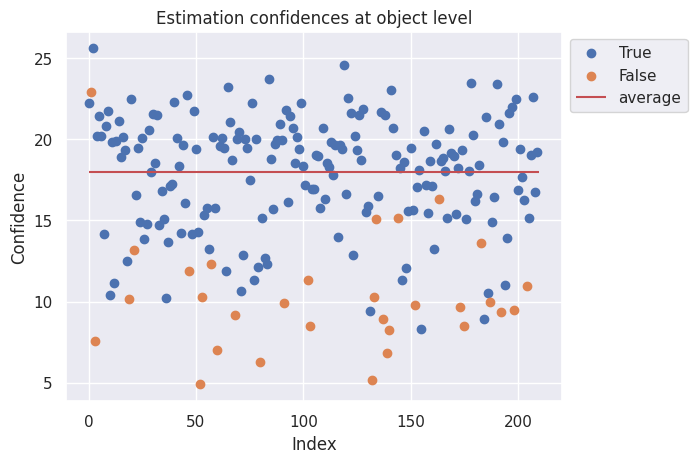

In [194]:

# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()
# average_decision_object = 17


print(df)
print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
up_data = df[df['decision'] >= average_decision_object]


print(classification_report(up_data['Actual'], up_data['prediction'],digits=3))

print("採用数:", len(up_data.index))
print("採用率:", len(up_data.index)/len_df)
# 閾値未満を抽出しDFを作成
down_data = df[df['decision'] < average_decision_object]

print("不採用数:",down_data.shape[0])
    

MapConfidence(df,'object',average_decision_object)

In [195]:
print(matLabel)

['clothing', 'bedding', 'memory-foam', 'paper', 'metal', 'wood', 'plastic']


(210, 7)
平均 decision: 3.580045
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000        15
           2      1.000     0.900     0.947        10
           3      0.923     1.000     0.960        12
           4      1.000     0.933     0.966        15
           5      0.952     1.000     0.976        20
           6      1.000     1.000     1.000        24

    accuracy                          0.980       101
   macro avg      0.982     0.976     0.978       101
weighted avg      0.981     0.980     0.980       101

採用数: 101
採用率: 0.48095238095238096
不採用: 109
     clothing   bedding  memory-foam     paper     metal      wood   plastic  \
3    0.406641  0.038004     1.243042 -0.654465 -1.120538  0.571168 -0.782904   
7   -1.218065 -1.006331    -1.050484  0.094344  3.046897  0.486336 -0.724970   
8   -0.305289  2.753593     1.106457 -0.874465 -0.833014 -0.855815 -0.781258   
10  -1.03

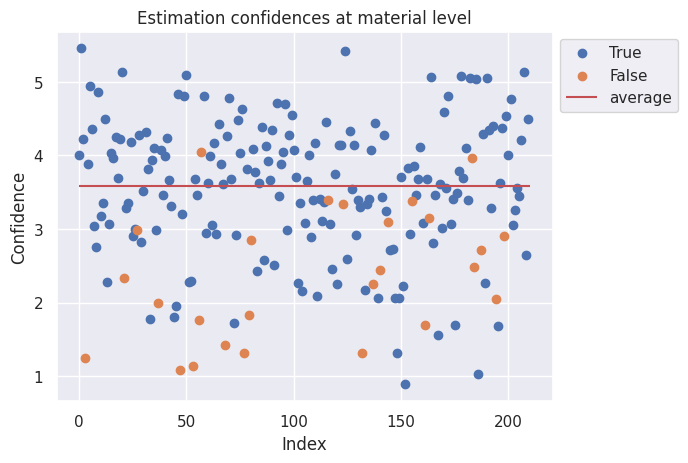

In [196]:
df,len_df = Hiera_report(matConfidences,matLabel,matPreds,matActuals)

# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
# df = df.iloc[down_data.index]

Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape[0])

print(Down_material)

MapConfidence(df,'material',average_decision_material)

(210, 2)
平均 decision: 2.7275383
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        41
           1      1.000     1.000     1.000        40

    accuracy                          1.000        81
   macro avg      1.000     1.000     1.000        81
weighted avg      1.000     1.000     1.000        81

採用数: 81
採用率: 0.38571428571428573
不採用: 129
RangeIndex(start=0, stop=210, step=1)


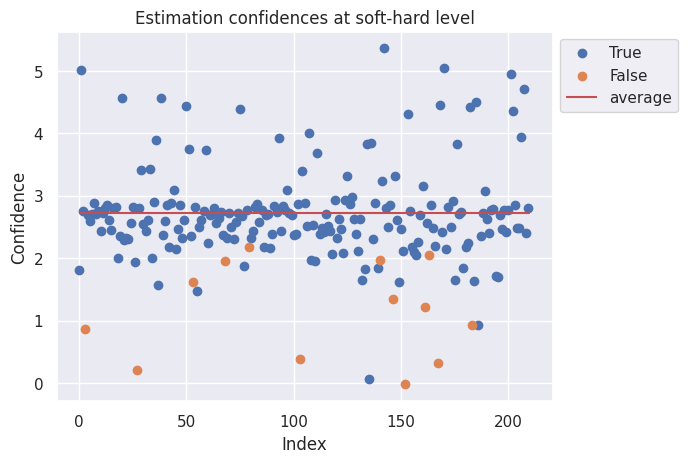

In [197]:
df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
# df = df.iloc[Down_material.index]
Up_softhard = df[df['decision'] >= average_decision_softhard]


print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape[0])

MapConfidence(df,'soft-hard',average_decision_softhard)

In [175]:


df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)


Down_all = df.iloc[Down_softhard.index]


print(classification_report(Down_all['Actual'], Down_all['prediction'],digits=3))


(210, 2)
              precision    recall  f1-score   support

           0      0.846     0.898     0.871        49
           1      0.935     0.900     0.917        80

    accuracy                          0.899       129
   macro avg      0.891     0.899     0.894       129
weighted avg      0.901     0.899     0.900       129



### 組み合わせた時の評価

In [108]:
# 正解率の計算
def EvalCNN_trained(data_loader,device,num_label,num_trial,model):
    with torch.no_grad():
        if num_label == 0:
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            confidence = y[0]
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        # #混同行列の作成
        # cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        # p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
        #                 xticklabels=label,
        #                 yticklabels=label)
        # title = "confusion_matrix_"+model_name
        # plt.title(title)
        # plt.xlabel('predict')
        # plt.ylabel('actual')
        # plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

In [209]:
df_hiera = pd.DataFrame()
df_all_confidence_obj = pd.DataFrame()
df_all_confidence_mat = pd.DataFrame()
df_all_confidence_sh = pd.DataFrame()


for eval_num in range(21):
    print(eval_num)
    start = eval_num*trials
    end = (eval_num+1)*trials

    test_feature = Dataset_melspec_tensor[start:end,:,:,:]
    test_labels = Dataset_label_tensor[start:end,:]
    print(test_labels.shape)


    # obj--------------------

    # tensorDatasetの作成
    label_num = 0

    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    test_loader = torch.utils.data.DataLoader(test, batch_size)

    model_path = 'data/models_saved/objModel_2_'+str(eval_num)+'.pth'
    objModel_eval = torch.load(model_path)
    objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,2,objModel_eval)

    df,len_df = Hiera_report(objConfidences,objLabel,objPreds,objActuals)

    # decision列の平均を計算

    a = average_decision_object 
    # a = 17
    print("平均 decision:", a)
    # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

    # 閾値以上を抽出しDFを作成
    up_data = df[df['decision'] >= a]

    # print("f1_score:",f1_score(up_data['Actual'], up_data['prediction'],average='weighted'))
    obj_pick = len(up_data.index)

    print("採用数:", obj_pick)
    print("採用率:", len(up_data.index)/len_df)
    # 閾値未満を抽出しDFを作成
    down_data = df[df['decision'] < a]

    print("不採用数:",down_data.shape[0])

    df_all_confidence_obj = pd.concat([df_all_confidence_obj,df],ignore_index=True)
    # mat------------------

    label_num = 1

    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    test_loader = torch.utils.data.DataLoader(test, batch_size)

    model_path = 'data/models_saved/matModel_2_'+str(eval_num)+'.pth'
    matModel_eval = torch.load(model_path)
    matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,2,matModel_eval)

    df,len_df = Hiera_report(matConfidences,matLabel,matPreds,matActuals)

    print(df)

    b = average_decision_material
    # b = 2.7
    print("平均 decision:", b)

    # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
    # 閾値以上を抽出しDFを作成
    # df = df.iloc[down_data.index]

    Up_material = df[df['decision'] >= b]

    f1_mat = f1_score(Up_material['Actual'], Up_material['prediction'],average='weighted')
    print("f1_score:",f1_mat)

    mat_pick = len(Up_material.index)
    print("採用数:", mat_pick)
    print("採用率:", len(Up_material.index)/len_df)

    # 閾値未満を抽出しDFを作成
    Down_material = df[df['decision'] < b]

    print("不採用:",Down_material.shape[0])
    
    df_all_confidence_mat = pd.concat([df_all_confidence_mat,df],ignore_index=True)

    # sh------------------


    label_num = 2

    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    test_loader = torch.utils.data.DataLoader(test, batch_size)

    model_path = 'data/models_saved/shModel_2_'+str(eval_num)+'.pth'
    shModel_eval = torch.load(model_path)
    shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,2,shModel_eval)

    df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)
    c =  average_decision_softhard
    # c = 2
    print("平均 decision:",c)
    # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
    # 閾値以上を抽出しDFを作成
    # df = df.iloc[Down_material.index]
    Up_softhard = df[df['decision'] >= c]

    f1_sh = f1_score(Up_softhard['Actual'], Up_softhard['prediction'],average='weighted')
    print("f1_score:",f1_sh)

    sh_pick = len(Up_softhard.index)
    print("採用数:", sh_pick)
    print("採用率:", len(Up_softhard.index)/len_df)

    # 閾値未満を抽出しDFを作成
    Down_softhard = df[df['decision'] < c]

    print("不採用:",Down_softhard.shape[0])

    df_all_confidence_sh = pd.concat([df_all_confidence_sh,df],ignore_index=True)


    # 新しい行のデータをリストまたはDataFrameとして準備
    new_rows = [obj_pick, mat_pick, f1_mat, sh_pick, f1_sh]

    # concat() を使用して新しい行を追加
    df_hiera = pd.concat([df_hiera, pd.DataFrame([new_rows])],ignore_index=True)
# df_hiera = df_hiera.rename(columns={'obj_pick','mat_pick','f1_mat','sh_pick','f1_sh'})

0
torch.Size([50, 3])
(50, 21)
平均 decision: 17.97886
採用数: 0
採用率: 0.0
不採用数: 50
(50, 7)
    clothing   bedding  memory-foam     paper     metal      wood   plastic  \
0  -0.541838  2.452364     0.695385 -0.601831 -0.391677 -0.880500 -0.655623   
1   2.207358 -0.748085     0.878197 -0.178092 -0.491530 -0.523776 -0.808893   
2  -0.725831  2.814282     0.592693 -0.566030 -0.371425 -1.000455 -0.649396   
3   0.838533 -0.202324     2.482806 -0.670907 -0.629491 -0.685959 -1.074503   
4   0.272159 -0.185186     2.408343 -0.431758 -0.431129 -0.666722 -0.839777   
5   1.840281 -0.607148     1.162601 -0.389854 -0.477287 -0.416966 -0.776226   
6   0.426861  1.060507     1.065097 -0.473786 -0.396637 -0.609074 -0.755466   
7   2.649708 -0.728693     0.718900 -0.284410 -0.594723 -0.565698 -0.784213   
8   0.946131 -0.788618     1.117446  0.477831 -0.215886 -0.635710 -0.743173   
9   1.592075 -0.628985     1.628177 -0.413824 -0.453653 -0.520956 -0.937116   
10  2.168859 -0.840777    -0.305995  0.357472

In [265]:
def MapConfidenceNotrained(df, level, avg):
    ##mapping decision
    interval = np.arange(0, len(df), 50)

    true_trial = df[df['prediction'] == df['Actual']]
    false_trial = df[df['prediction'] != df['Actual']]

    x_true = true_trial.index
    y_true = true_trial['decision']

    x_false = false_trial.index
    y_false = false_trial['decision']

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_true, y_true, label='True', s=10)
    ax.scatter(x_false, y_false, label='False', s=10)

    # ylimを取得
    ylim = ax.get_ylim()

    # 水平線と垂直線を描画
    ax.hlines(avg, 0, len(df), colors='r', label='average')
    ax.vlines(interval, ylim[0], ylim[1], colors='0', linestyles='dotted')

    # タイトル、軸ラベル、凡例の設定
    title = 'Scatter estimation confidences at ' + level + ' level'
    ax.set_title(title)  
    ax.set_xlabel('Index')
    ax.set_ylabel('Confidence')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # ylimの設定
    ax.set_ylim(ylim)

    #グラフを保存
    plt.savefig("data/output_data/"+title+".pdf")

    # グラフを表示
    plt.show()

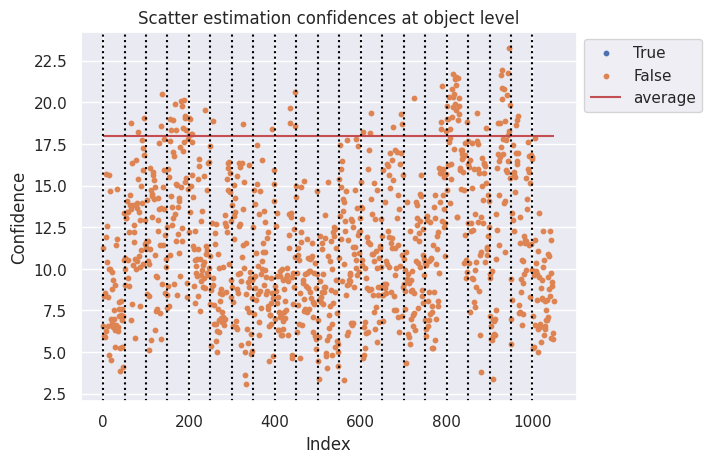

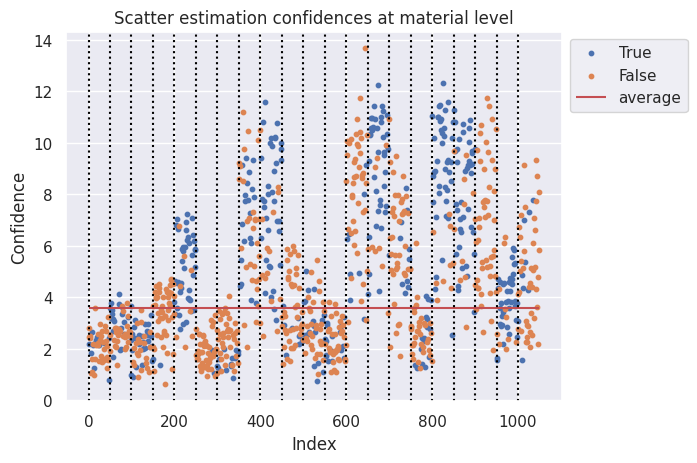

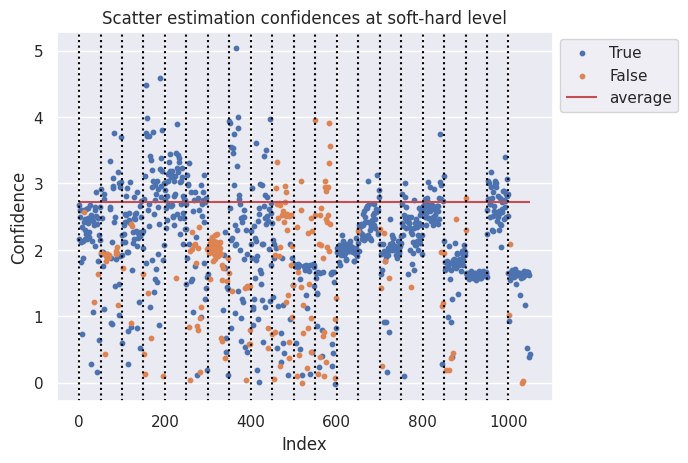

In [266]:
MapConfidenceNotrained(df_all_confidence_obj,'object',average_decision_object)
MapConfidenceNotrained(df_all_confidence_mat,'material',average_decision_material)
MapConfidenceNotrained(df_all_confidence_sh,'soft-hard',average_decision_softhard)

In [111]:
df_hiera.round(3)

,0,1,2,3,4
0,0,1,0.000,1,1.0
1,3,8,0.857,8,1.0
2,2,0,NaN,6,1.0
3,12,15,0.000,7,1.0
4,6,34,0.938,5,1.0
5,1,0,NaN,12,1.0
6,1,1,0.000,0,NaN
7,1,46,0.606,0,NaN
8,4,41,0.845,1,1.0
9,0,18,0.105,2,0.0


In [267]:
#混同行列の生成
df_all_confidence_obj


#混同行列の作成
def MakeConfusionMatrix(actual,predict,target,subject):
    cm = confusion_matrix(y_true=actual,y_pred=predict)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #グラフを保存
    plt.savefig("data/output_data/"+title+".pdf")
    
    plt.show()


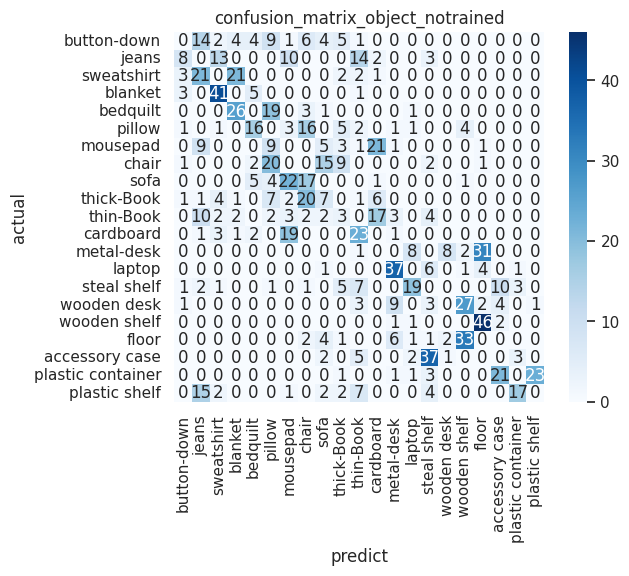

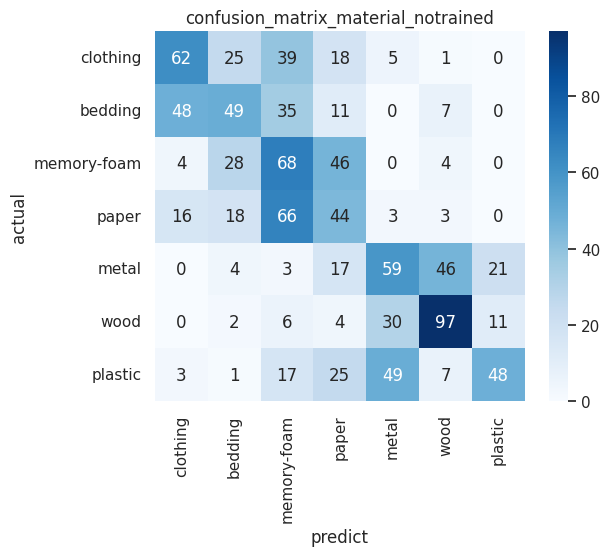

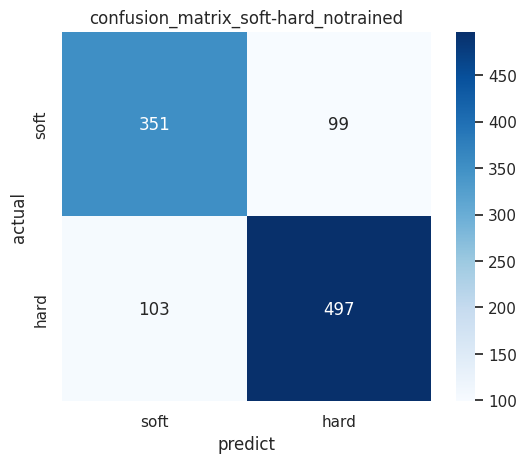

In [268]:
MakeConfusionMatrix(actual = df_all_confidence_obj['Actual'],
predict = df_all_confidence_obj['prediction'],
target = objLabel,
subject = 'object_notrained')

MakeConfusionMatrix(actual = df_all_confidence_mat['Actual'],
predict = df_all_confidence_mat['prediction'],
target = matLabel,
subject = 'material_notrained')

MakeConfusionMatrix(actual = df_all_confidence_sh['Actual'],
predict = df_all_confidence_sh['prediction'],
target = shLabel,
subject = 'soft-hard_notrained')